In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_GenText
from inter.simpleInteraction import simpleInteraction as inter

from outil import *

# Environement
Nous prennons un environnement pour obtenir les tokens que nous voulons générer

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


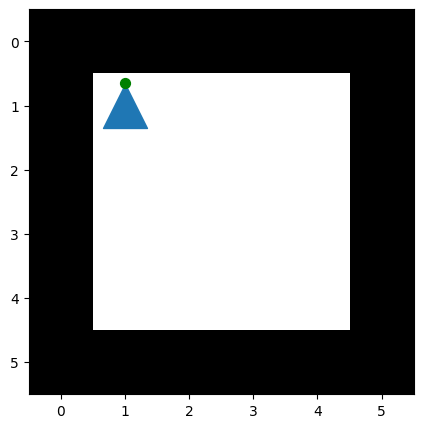

In [2]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []
env_test.display_world()

# Liste vocab
Nous pouvons maintenant définir notre liste de vocabulaire et notre tokenizer

In [3]:
list_vocab = ['<pad>']
# Nous notons tout les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)
# Test tokenizer
# print(tokenizer.encode(("forward", "empty")))
# print(tokenizer.encode("<pad>"))

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}


# Génération de texte
## Entrainement ?

Dans notre cas nous n'avons pas de données au début, l'agent n'a pas encore intéragit avec son environement. Donc nous n'avons pas de train possible.

## Prompt
Mais pour que le LSTM génére du texte il nous faut un prompt. Pour se faire nous avons plusieurs possiblité, soit nous appliquons une action de base (Ce qui est fait pour les agents précédent) soit nous lui donnons le token \<pad\>. Vue que le modèl n'est pas entrainner cela n'a pas d'importence. A noter que si plus tard nous lui donnons un entrainement qui utilise \<pad\> Alors il n'est plus pertinent d'utiliser cette balise comme cela.

In [4]:
# Mots que l'on veut prompt (ca doit être une liste)
input_tokens = tokenizer.encode(["<pad>"])

# Model
Nous pouvons maintenant definir le modèl, nous prennons une configuration de base.

In [5]:
# Model
torch.manual_seed(1)
num_layers = 2
hidden_size = 128
temp = 1.0
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)


## Première génération

In [6]:
torch.manual_seed(1)
# Nous devons reshape input_tokens pour qu'il soit de la forme (1, -1)
# Pour résumer nous ajoutons une dimension pour le batch
input_tokens = tokenizer.encode(["<pad>"])
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
print("\033[0;32m le tensor input : \033[0m")
print(input_tokens)
lstm_generator.eval()
log_tokens = []

def generate_sentence(lstm_generator, input_tokens):
    # Disable gradient calculation
    with torch.no_grad():    
        # Initialize hidden and memory states
        hidden = torch.zeros(num_layers, 1, hidden_size)
        memory = torch.zeros(num_layers, 1, hidden_size)

        # Generate text
        for i in range(100): # On met une limite de 100 tokens
            # Forward pass through LSTM generator
            data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

            # Sample from the distribution of probabilities (with temperature)
            dist = Categorical(logits=data_pred[:, -1] / temp)
            input_tokens = dist.sample().reshape(1, 1)

            # Append generated token to log_tokens
            log_tokens.append(input_tokens.cpu())

            # Check for end-of-sentence token
            if input_tokens.item() == tokenizer.encode(('forward', 'empty')): # Si le token est ('forward', 'empty') on s'arrête
                break
    return log_tokens, data_pred

log_tokens, data_pred = generate_sentence(lstm_generator, input_tokens)
print()
print("\033[0;32m les tensor d'output :\033[0m")
for i in log_tokens:
    print(tokenizer.decode(i.item()))
print(log_tokens)



 le tensor input : 
tensor([[0]])

 les tensor d'output :
('feel_left', 'empty')
<pad>
('turn_right', 'empty')
('feel_front', 'wall')
('turn_left', 'empty')
('forward', 'empty')
[tensor([[8]]), tensor([[0]]), tensor([[4]]), tensor([[5]]), tensor([[3]]), tensor([[2]])]


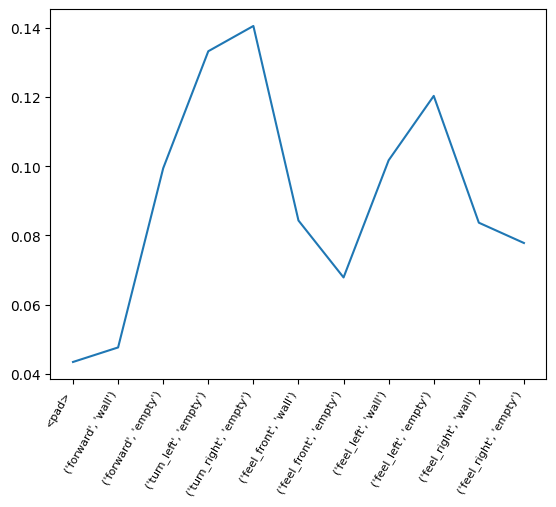

In [7]:
# La distribution de probabilité
# ce qui correspond à la prédiction du modèle pour le prochain token
# Cette distribution est calculée avec la fonction softmax et dépand de la température
plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())

## Output
Ce que le modèl sort est très variable si nous ne fixons pas la seed. Le modèl propose une distribution corespondant à l'initialisation de ses poids (aléatoirement).

## Appliquation de la génération
Avec notre premier output nous pouvons demander à notre "agent" d'appliquer les actions des tokens pour vérifier si les prédictions sont bonne ou non. 
De manière évidente en début les prédictions ont que très peu de chance d'être bonne. Ce qui est normal l'agent doit découvrir son environement.


In [8]:
def run_token(tokens:torch.Tensor, env):
    """Applique toutes les actions des tokens

    Args:
        token (torch.Tensor): La sortie brut du modèle de prédiction
        env (env): L'environnement dans lequel on veut appliquer les actions

    Returns:
        list: La liste des actions
        list: La liste des outcomes
    """
    actions = []
    outcomes = []
    for tok in tokens:
        interaction:tuple|str = tokenizer.decode(tok.item())
        if interaction in ["<pad>"]: # Liste des tokens qui ne correspondent à aucune action
            continue
        actions.append(interaction[0]) # On ajoute l'action à la liste
        outcomes.append(env.outcome(actions[-1])) # On récupère l'outcome de l'action
    return actions, outcomes

In [9]:
tokens = log_tokens
actions, outcomes = run_token(tokens, env_test)
print("Les actions tirées de la génération du modèle")
print(actions)
print("Les outcomes réel de l'environnement")
print(outcomes)

Les actions tirées de la génération du modèle
['feel_left', 'turn_right', 'feel_front', 'turn_left', 'forward']
Les outcomes réel de l'environnement
['wall', 'empty', 'empty', 'empty', 'wall']


# Train
## Jeu de données
Pour entrainer le modèle, il nous faut des données. Nous pouvons récupérer les interactions que "l'agent" à fait.
### Traitement des interactions
Nous avons les actions et outcomes, nous devons les transformers en token. Il nous faut une taille de contexte pour que l'entrainement soit fixe (cela améliore les performances). Nous pouvons prendre une grande taille que nous comblerons par des \<pad\>

In [10]:
def action_outcome_to_token(actions, outcomes):
    token = []
    for i in range(len(actions)):
        token.append(tokenizer.encode((actions[i], outcomes[i])))
    return token

print(f"\033[0;32mLes actions\033[0m {actions} \n\033[0;32met outcomes\033[0m {outcomes}")
seq_token = action_outcome_to_token(actions, outcomes)
print(f"\033[0;32mLes tokens déduit\033[0m {seq_token}")


Les actions ['feel_left', 'turn_right', 'feel_front', 'turn_left', 'forward'] 
et outcomes ['wall', 'empty', 'empty', 'empty', 'wall']
Les tokens déduit [7, 4, 6, 3, 1]


In [11]:
# Création du data set :
def create_data(tokens, context_lenght, padding, min = 1):
    """
    Create the data
    """
    sentences = []
    for range_cut in range(min, len(tokens) +1):
        for i in range(0, len(tokens) +1 - range_cut, 1):
            sentences.append(tokens[i:i + range_cut])
            sentences[-1] = sentences[-1] + [padding] * (context_lenght - len(sentences[-1]))
    return sentences

data_set = create_data(seq_token, 10, tokenizer.encode("<pad>"))
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)
    # print(tokenizer.decode(i))
    # print()

Le data set
[7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[7, 4, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 6, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 3, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[7, 4, 6, 0, 0, 0, 0, 0, 0, 0]
[4, 6, 3, 0, 0, 0, 0, 0, 0, 0]
[6, 3, 1, 0, 0, 0, 0, 0, 0, 0]
[7, 4, 6, 3, 0, 0, 0, 0, 0, 0]
[4, 6, 3, 1, 0, 0, 0, 0, 0, 0]
[7, 4, 6, 3, 1, 0, 0, 0, 0, 0]


### Data set
Maintenant que le data set est créer nous pouvons utiliser pytorch pour gérer notre data train. (Nous mettons aussi les données sous forme de tensor)

In [12]:
class CustomDataSetTextGenByToken(Dataset):
    def __init__(self, token, context_lenght:int, id_pad:int=0, min:int = 1):
        """
        Creates a custom dataset
        """
        # Je ne suis pas sur d'y garder
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        # assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.token = token
        self.padding = id_pad
        self.min = min
        self.data = self.create_data()

    def create_data(self):
        """
        Create the data
        """
        sentences = []
        for range_cut in range(self.min, len(self.token) +1):
            for i in range(0, len(self.token) +1 - range_cut, 1):
                sentences.append(self.token[i:i + range_cut])
                sentences[-1] = sentences[-1] + \
                                [self.padding] * (self.context_lenght - len(sentences[-1]))
        return sentences

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return torch.tensor(self.data[idx])
    
data_set = CustomDataSetTextGenByToken(
    token=seq_token,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=10,
    min=1)
print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)


Le data set
tensor([7, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([3, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 6, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 3, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([3, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 6, 0, 0, 0, 0, 0, 0, 0])
tensor([4, 6, 3, 0, 0, 0, 0, 0, 0, 0])
tensor([6, 3, 1, 0, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 6, 3, 0, 0, 0, 0, 0, 0])
tensor([4, 6, 3, 1, 0, 0, 0, 0, 0, 0])
tensor([7, 4, 6, 3, 1, 0, 0, 0, 0, 0])


### Data loader

In [13]:
data_loader_train = DataLoader(
    data_set,
    batch_size=1,
    shuffle=True,
    num_workers=8
)

### Loss et opti

In [17]:
opti = optim.Adam(lstm_generator.parameters(), lr=0.001)
loss_fct = nn.CrossEntropyLoss()

## Training

In [ ]:
def train(lstm_generator, nb_epoch:int, optimizer, loss_fn):
    # Monitor training loss and entropy
    training_loss_logger = []
    entropy_logger = []

    for epoch in tqdm(range(nb_epoch)):
        # Set LSTM generator model to training mode
        lstm_generator.train()
        steps = 0
        # Iterate over batches in training data loader
        for text in tqdm(data_loader_train, desc="Training", leave=False):
            # Transform text tokens using training transform and move to device
            bs = text.shape[0]
            
            # Randomly drop input tokens
            # input_text = td(text_tokens[:, 0:-1])
            # output_text = text_tokens[:, 1:]
            input_text = text[:, 0:-1]
            output_text = text[:, 1:]
            
            # Initialize the memory buffers
            hidden = torch.zeros(num_layers, bs, hidden_size)
            memory = torch.zeros(num_layers, bs, hidden_size)
            
            # Forward pass through the LSTM generator
            pred, hidden, memory = lstm_generator(input_text, hidden, memory)

            # Calculate loss
            loss = loss_fn(pred.transpose(1, 2), output_text)
            
            # Zero gradients, perform backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log training loss
            training_loss_logger.append(loss.item())
            
            # Log entropy during training (for monitoring)
            with torch.no_grad():
                dist = Categorical(logits=pred)
                entropy_logger.append(dist.entropy().mean().item())
    return training_loss_logger, entropy_logger
 
training_loss_logger, entropy_logger = train(lstm_generator, 50, opti, loss_fct)
# Display training loss and entropy
plt.plot(training_loss_logger)
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

plt.plot(entropy_logger)
plt.xlabel('Training Steps')
plt.ylabel('Entropy')
plt.title('Entropy')
plt.show()

NameError: name 'lstm_generator' is not defined

# Boucle
Maintenant que nous avons vue toutes les étapes, nous pouvons tenter de faire un modèle qui comprends l'environement !  
Il est important de noté qu'il n'y a aucune volonté un certain chemin. Le modèle peut tout a fait apprendre "forward", "wall" en boucle.